In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
import re
import os
import seaborn as sns
from matplotlib import cm, colors

In [63]:
PATH = os.getcwd()
TEST_FOLDER = 'test-result'
REGGRESSION_FOLDER = 'regressions'
PARAMETRIC_FOLDER = 'parametric'
ACENTUACION_FOLDER = 'Acentuacion'
CADENCIA_FOLDER = 'Cadencia'
INTELIGIBILIDAD_FOLDER = 'Inteligibilidad'
NATURALIDAD_FOLDER = 'Naturalidad'
PRONUNCIACION_FOLDER = 'Pronunciacion'
MALE_FOLDER = 'masculino'
FEMALE_FOLDER = 'femenino'

In [64]:
# Diccionario para guardar los p-value
dicc_p_value = {
    'subjetive_parameter':[],
    'ZCR':[],
    'RMS':[],
    'f0':[],
    'selected_features':[],
    'genero':[] 
}

In [65]:
# Voy a limpiar los graficos que hay en las carpetas

list_files = os.listdir(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER))

list_folder = []
for folder in list_files:
    if not folder.endswith('.xlsx'):
        list_folder.append(folder)
        
SUBFOLDER_GENDER = ['masculino', 'femenino']

for folder in list_folder:
    for gender in SUBFOLDER_GENDER:
        os.chdir(os.path.join(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, folder, gender)))
        all_files = os.listdir()
        if len(all_files) == 0:
            continue
        for f in all_files:
            os.remove(f)

os.chdir(PATH)

In [66]:
list_folder

['Acentuacion', 'Cadencia', 'Inteligibilidad', 'Naturalidad', 'Pronunciacion']

In [67]:
merged_df = pd.read_csv(r'aux_file\data_regression.csv')

In [68]:
obj_params = pd.read_excel('voces_test_rms.ods')

In [69]:
obj_params.head()

,zero_crossing_rate,rms,mfcc,pitch,genero,file
0,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino,hyacinthe-lovo-v3.wav
1,0.093035,-27.0,[-424.61664 138.61742 -14.495688 3...,101.312090,femenino,lola-murf.wav
2,0.093043,-22.5,[-3.71418152e+02 1.31561859e+02 -1.60284328e+...,76.492752,masculino,neural2B-GCP.wav
3,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino,alonso-naturalreader.wav
4,0.105458,-21.5,[-3.5115176e+02 1.1943483e+02 -1.9279911e+01 ...,69.045778,masculino,antonio-murf.wav


In [70]:
df_union = pd.merge(
    merged_df,
    obj_params,
    how='left',
    left_on='filename',
    right_on='file'
).drop(columns=['file'])

In [71]:
df_union.rename(
    columns={
        'zero_crossing_rate': 'zcr',
        'pitch': 'f0'
    },
    inplace=True
)

In [72]:
df_union.head()

,ID,filename,Inteligibilidad,Pronunciacion,Acentuacion,Naturalidad,Cadencia,zcr,rms,mfcc,f0,genero
0,1,alonso-naturalreader.wav,4.867647,4.621212,4.426471,3.250000,3.823529,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino
1,2,hyacinthe-lovo-v3.wav,4.970588,4.692308,4.602941,4.308824,4.250000,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino
2,3,neural2C-pitchmodified-speedmodified.wav,4.515625,3.962963,2.852941,1.779412,1.720588,0.251626,-25.0,[-4.4141333e+02 8.9362648e+01 -1.2164741e+01 ...,98.468505,masculino
3,4,francisca-lovo-v2.wav,4.746269,4.276923,4.294118,3.220588,3.823529,0.137822,-26.1,[-454.8679 72.41395 -14.8625145 45.9...,116.353345,femenino
4,5,antoni-evenlabs-linguistico-v2.wav,4.681818,4.064516,3.220588,1.897059,1.779412,0.239188,-24.0,[-406.19888 84.30505 -12.89493 18.8...,78.968152,masculino


## SelectorFeature

In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.utils import check_random_state
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm

In [74]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """Un envoltorio para hacer que los modelos de regresión de statsmodels sean compatibles con la API de scikit-learn"""
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.model = None

    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model = self.model_class(y, X)
        self.results = self.model.fit()
        return self.results

    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results.predict(X)

### Inteligibilidad

In [75]:
df_inteligibilidad = df_union.loc[:, ['Inteligibilidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [76]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'masculino'

df_inteligibilidad_male = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [77]:
# Cargamos los datos
X = np.array(df_inteligibilidad_male.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_male.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.1397
Característica RMS: p-valor = 0.4971
Característica f0: p-valor = 0.6041


In [78]:
selected_features

(0,)

In [79]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [80]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -2.32 * ZCR + 5.05 - p-valor = 0.140


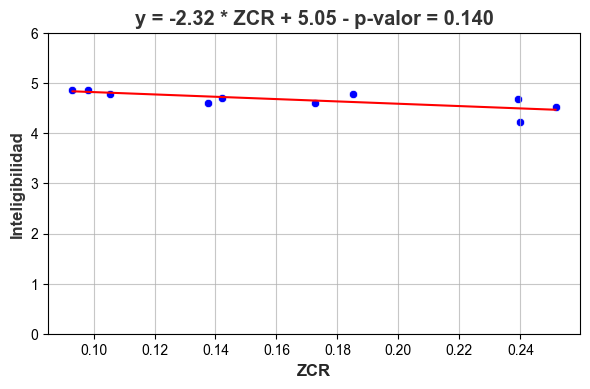

In [81]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresiones_inteligibilidad_male.png'))
    plt.show()


In [82]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresion_inteligibilidad_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [83]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'femenino'

df_inteligibilidad_female = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [84]:
# Cargamos los datos
X = np.array(df_inteligibilidad_female.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_female.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0, 2)
Característica ZCR: p-valor = 0.0324
Característica RMS: p-valor = 0.6260
Característica f0: p-valor = 0.0539


In [85]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [86]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -2.26 * ZCR + 5.09 - p-valor = 0.032
y = -0.01 * $f_{0}$ + 5.29 - p-valor = 0.054


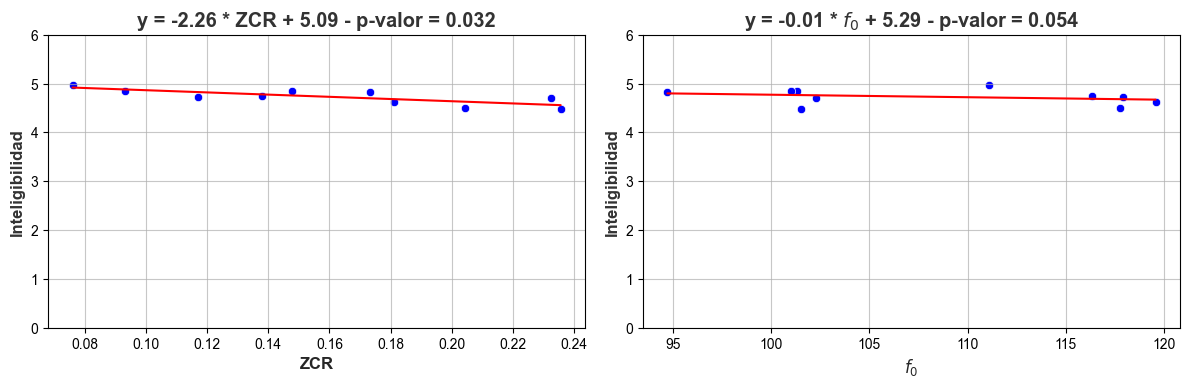

In [87]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(
        os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_inteligibilidad_female.png')
    )
    plt.show()


In [88]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresion_inteligibilidad_multivariable_female.html')
    )

    fig.show()


### Pronunciacion

In [89]:
df_pronunciacion = df_union.loc[:, ['Pronunciacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [90]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'masculino'

df_pronunciacion_male = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [91]:
# Cargamos los datos
X = np.array(df_pronunciacion_male.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_male.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0, 1)
Característica ZCR: p-valor = 0.0077
Característica RMS: p-valor = 0.0483
Característica f0: p-valor = 0.3416


In [92]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [93]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -3.07 * ZCR + 4.81 - p-valor = 0.008
y = 0.06 * RMS + 5.69 - p-valor = 0.048


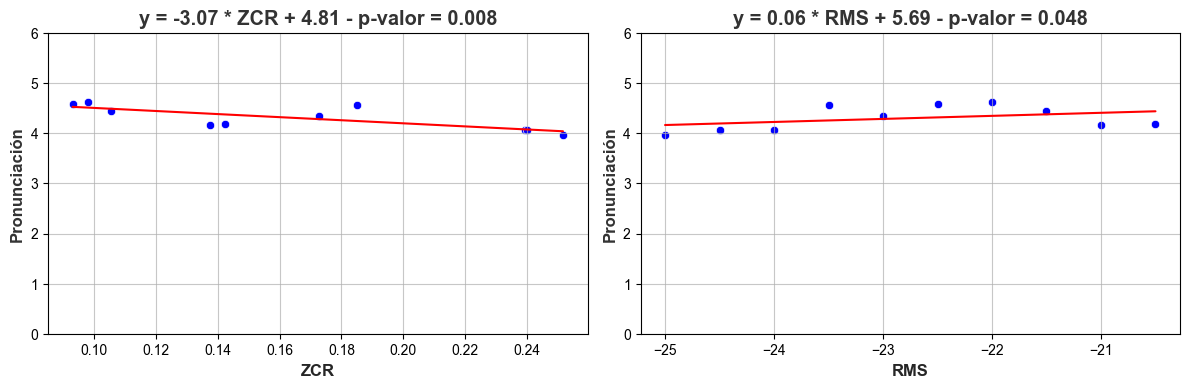

In [94]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresiones_pronunciacion_male.png'))
    plt.show()


In [95]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresion_pronunciacion_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [96]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'femenino'

df_pronunciacion_female = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [97]:
# Cargamos los datos
X = np.array(df_pronunciacion_female.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_female.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0, 2)
Característica ZCR: p-valor = 0.1217
Característica RMS: p-valor = 0.7014
Característica f0: p-valor = 0.0722


In [98]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [99]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -2.51 * ZCR + 4.79 - p-valor = 0.122
y = -0.01 * $f_{0}$ + 5.37 - p-valor = 0.072


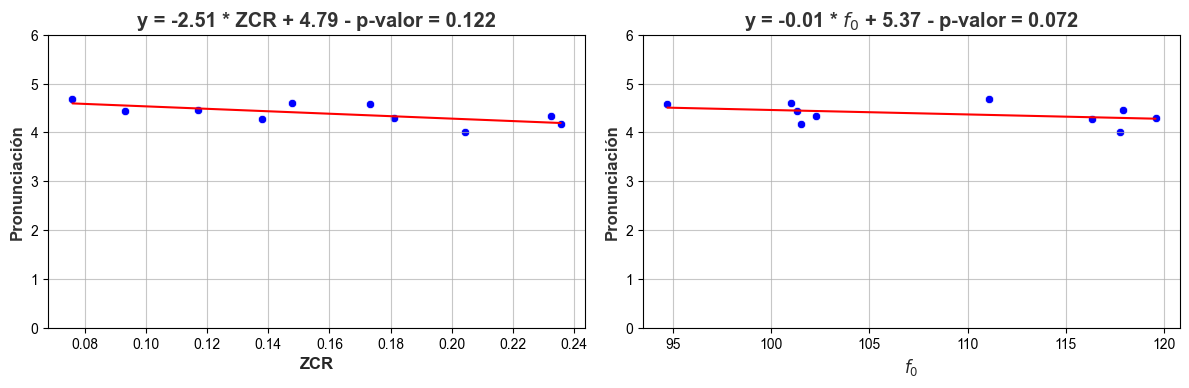

In [100]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresiones_pronunciacion_female.png'))
    plt.show()


In [101]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresion_pronunciacion_multivariable_female.html')
    )

    fig.show()


### Acentuacion

In [102]:
df_acentuacion = df_union.loc[:, ['Acentuacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [103]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'masculino'

df_acentuacion_male = df_acentuacion[mask_gender].drop(columns=['genero'])

In [104]:
# Cargamos los datos
X = np.array(df_acentuacion_male.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_male.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.0168
Característica RMS: p-valor = 0.1353
Característica f0: p-valor = 0.3779


In [105]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [106]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -8.08 * ZCR + 5.08 - p-valor = 0.017


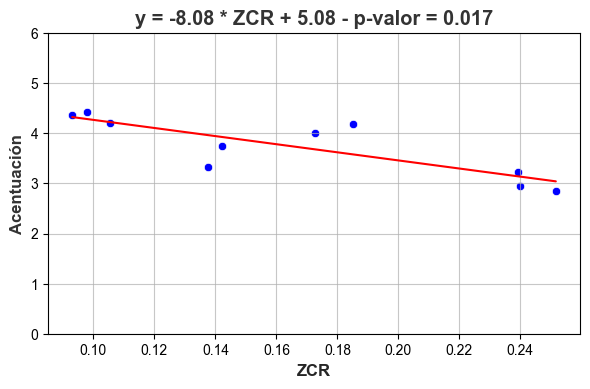

In [107]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresiones_acentuacion_male.png'))
    plt.show()


In [108]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Acentuación', zaxis=dict(range=[0, 6])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresion_acentuacion_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [109]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'femenino'

df_acentuacion_female = df_acentuacion[mask_gender].drop(columns=['genero'])

In [110]:
# Cargamos los datos
X = np.array(df_acentuacion_female.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_female.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (1, 2)
Característica ZCR: p-valor = 0.4835
Característica RMS: p-valor = 0.3797
Característica f0: p-valor = 0.1105


In [111]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [112]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = 0.18 * RMS + 9.16 - p-valor = 0.380
y = -0.02 * $f_{0}$ + 6.52 - p-valor = 0.111


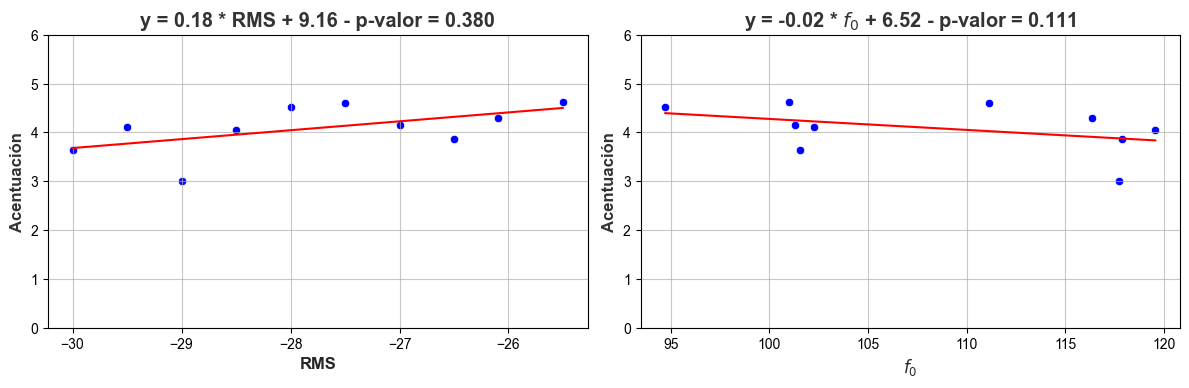

In [113]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresiones_acentuacion_female.png'))
    plt.show()


In [114]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Acentuación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresion_acentuacion_multivariable_female.html')
    )

    fig.show()


### Naturalidad

In [115]:
df_naturalidad = df_union.loc[:, ['Naturalidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [116]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'masculino'

df_naturalidad_male = df_naturalidad[mask_gender].drop(columns=['genero'])

In [117]:
# Cargamos los datos
X = np.array(df_naturalidad_male.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_male.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.0144
Característica RMS: p-valor = 0.9226
Característica f0: p-valor = 0.7219


In [118]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [119]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -11.44 * ZCR + 4.66 - p-valor = 0.014


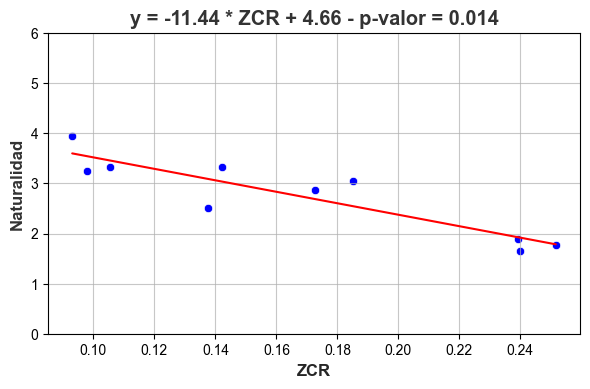

In [120]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresiones_naturalidad_male.png'))
    plt.show()


In [121]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresion_naturalidad_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [122]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'femenino'

df_naturalidad_female = df_naturalidad[mask_gender].drop(columns=['genero'])

In [123]:
# Cargamos los datos
X = np.array(df_naturalidad_female.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_female.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (1, 2)
Característica ZCR: p-valor = 0.1165
Característica RMS: p-valor = 0.3008
Característica f0: p-valor = 0.0680


In [124]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [125]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = 0.36 * RMS + 13.09 - p-valor = 0.301
y = -0.03 * $f_{0}$ + 6.07 - p-valor = 0.068


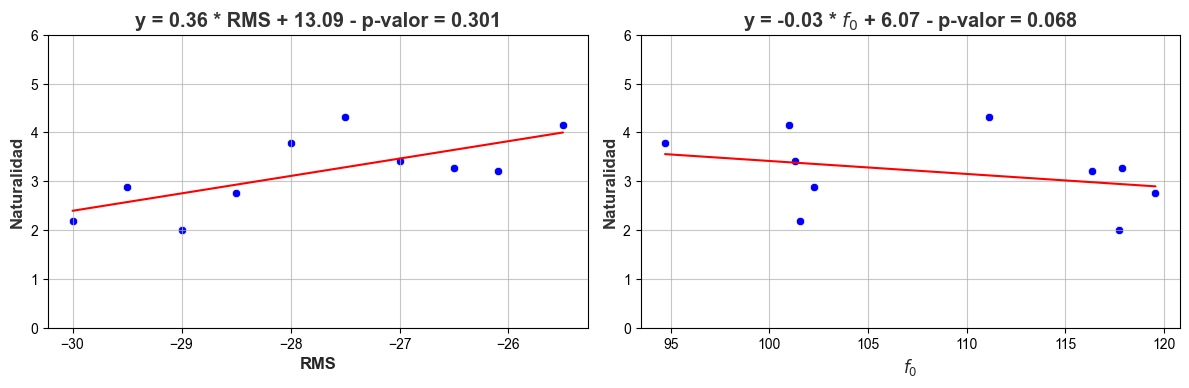

In [126]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_naturalidad_female.png'))
    plt.show()


In [127]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresion_naturalidad_multivariable_female.html')
    )

    fig.show()


### Cadencia

In [128]:
df_cadencia = df_union.loc[:, ['Cadencia', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [129]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'masculino'

df_cadencia_male = df_cadencia[mask_gender].drop(columns=['genero'])

In [130]:
# Cargamos los datos
X = np.array(df_cadencia_male.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_male.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.0036
Característica RMS: p-valor = 0.2866
Característica f0: p-valor = 0.8908


In [131]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [132]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -13.5 * ZCR + 5.1 - p-valor = 0.004


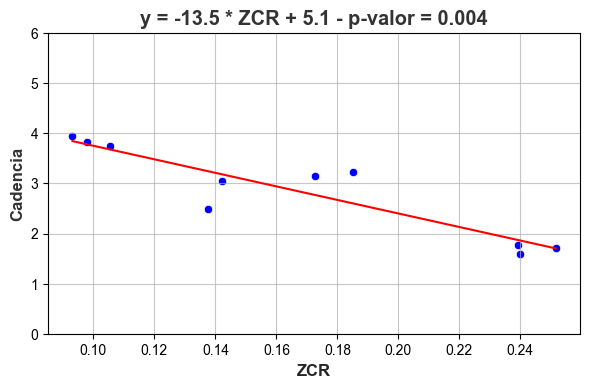

In [133]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresiones_cadencia_male.png'))
    plt.show()


In [134]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[75, 80, 85, 90, 95])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresion_cadencia_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [135]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'femenino'

df_cadencia_female = df_cadencia[mask_gender].drop(columns=['genero'])

In [136]:
# Cargamos los datos
X = np.array(df_cadencia_female.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_female.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal con el envoltorio
regr_multivar = SMWrapper(sm.OLS)

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
results = regr_multivar.fit(X, y)

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0, 1, 2)
Característica ZCR: p-valor = 0.0800
Característica RMS: p-valor = 0.0495
Característica f0: p-valor = 0.0197


In [137]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar_fit

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [138]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.params[1:][0]
    b = model.params[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w.round(2)} * {label} + {b.round(2)} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)

y = -10.88 * ZCR + 5.13 - p-valor = 0.080
y = 0.42 * RMS + 15.17 - p-valor = 0.049
y = -0.03 * $f_{0}$ + 6.38 - p-valor = 0.020


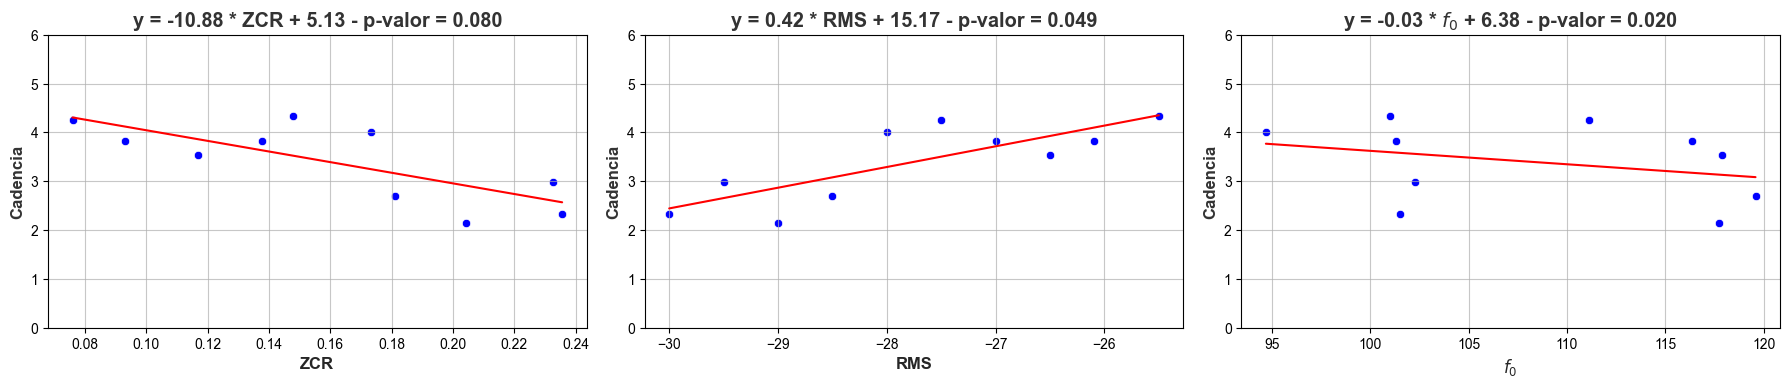

In [139]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresiones_cadencia_female.png'))
    plt.show()


In [140]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SMWrapper(sm.OLS)
    regr_multivar_fit = regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar_fit.params[0] + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar_fit.params[1:].ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar_fit.params[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar_fit.params[1:][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115, 120])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresion_cadencia_multivariable_female.html')
    )

    fig.show()

## Output p-values regressions

In [141]:
df_output_p_value_regression = pd.DataFrame(dicc_p_value)

In [142]:
# Crea un diccionario para mapear los valores
map_dict = {0: 'ZCR', 1: 'RMS', 2: 'F0'}

df_output_p_value_regression['selected_features'] = df_output_p_value_regression['selected_features'].apply(lambda x: [map_dict[val] for val in x])

In [143]:
df_output_p_value_regression

,subjetive_parameter,ZCR,RMS,f0,selected_features,genero
0,Inteligibilidad,0.139718,0.497109,0.604144,[ZCR],masculino
1,Inteligibilidad,0.032362,0.626043,0.053901,"[ZCR, F0]",femenino
2,Pronunciación,0.007719,0.048266,0.341597,"[ZCR, RMS]",masculino
3,Pronunciación,0.121680,0.701415,0.072164,"[ZCR, F0]",femenino
4,Acentuación,0.016766,0.135261,0.377902,[ZCR],masculino
5,Acentuación,0.483493,0.379710,0.110539,"[RMS, F0]",femenino
6,Naturalidad,0.014413,0.922624,0.721899,[ZCR],masculino
7,Naturalidad,0.116543,0.300801,0.068012,"[RMS, F0]",femenino
8,Cadencia,0.003614,0.286572,0.890817,[ZCR],masculino
9,Cadencia,0.080017,0.049479,0.019715,"[ZCR, RMS, F0]",femenino


In [82]:
df_output_p_value_regression.to_excel(
    os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, 'output_p_values_parametric_regressions.xlsx'),
    index=False
)